In [25]:
import os
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import load_img

print(tf.version.VERSION)

2.16.1


In [2]:
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

In [3]:
from  IPython import display
from matplotlib import pyplot as plt

import pathlib
import shutil
import tempfile

# Load Hotdog Image

In [4]:
BATCH_SIZE = 32
SIDE_LEN = 128

In [5]:
data_dir = "/Users/brenthoang/Documents/Test_Project/hot-dog/model/original/train"
test_dir = "/Users/brenthoang/Documents/Test_Project/hot-dog/model/original/test"

In [6]:
os.listdir(data_dir)

['.DS_Store', 'not_hotdog', 'hotdog']

In [7]:
# import image
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  image_size=(SIDE_LEN, SIDE_LEN),  # Resize all images to this size
  batch_size=BATCH_SIZE,
  label_mode='binary',  # Use 'binary' for two-class classification
  validation_split=0.2,  # Split 20% of data for validation
  subset='training',
  seed=123)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  image_size=(SIDE_LEN, SIDE_LEN),  # Resize all images to this size
  batch_size=BATCH_SIZE,
  label_mode='binary',  # Use 'binary' for two-class classification
  validation_split=0.2,  # Split 20% of data for validation
  subset='validation',
  seed=123)


test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  image_size=(SIDE_LEN, SIDE_LEN),  # Resize all images to this size
  batch_size=BATCH_SIZE,
  label_mode='binary'
)

Found 3000 files belonging to 2 classes.
Using 2400 files for training.
Found 3000 files belonging to 2 classes.
Using 600 files for validation.
Found 644 files belonging to 2 classes.


In [8]:
# mapping hotdog to 1 and not hotdog to 0

train_ds = train_ds.map(
    lambda image, label: (image, tf.cast(label == 0, tf.int32))
)

val_ds = val_ds.map(
    lambda image, label: (image, tf.cast(label == 0, tf.int32))
)

test_ds = test_ds.map(
    lambda image, label: (image, tf.cast(label == 0, tf.int32))
)

In [9]:
def plot_images(dataset, num_images=9):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
        for i in range(num_images):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            label = 'Hotdog' if labels[i] == 1 else 'Not Hotdog'
            plt.title(label)
            plt.axis("off")
    plt.show()

2024-08-01 12:49:51.105476: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


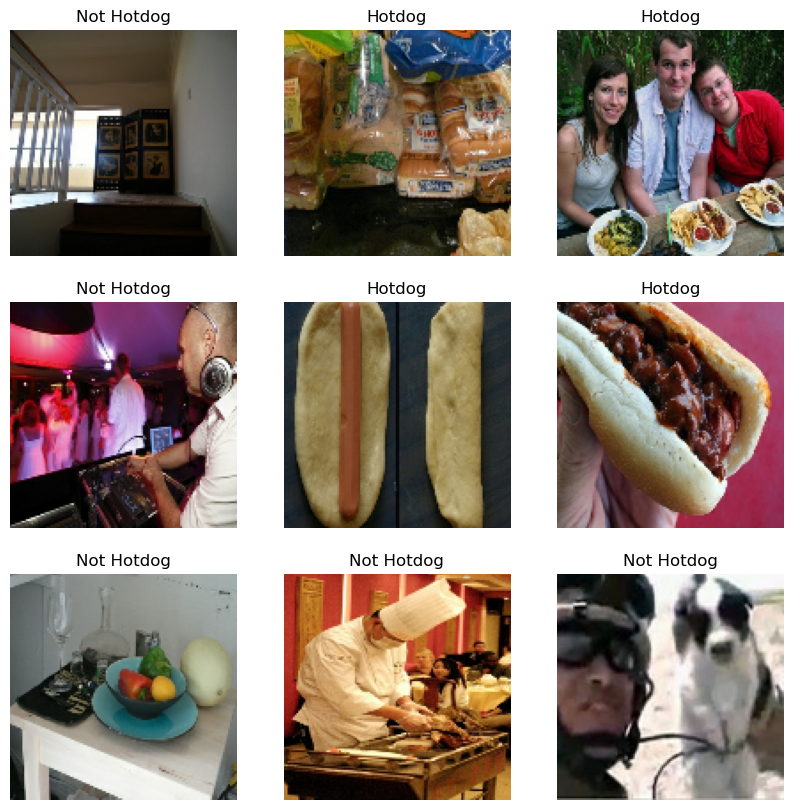

In [10]:
plot_images(train_ds)

# Create Checkpoint

In [13]:
checkpoint_path = "training_2/cp-{epoch:04d}.weights.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

import math
n_batches = math.ceil(len(train_ds))

In [14]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq=5*n_batches)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5,restore_best_weights=True
)

# Optimize Runtime and Create Model

Further Improvement:
- image augmentation (rotate, mirror, distortion)
- dropout
- weight regulizers 

In [15]:
# cache and prefetch for runtime
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [16]:
def create_model(): 
    model = tf.keras.Sequential([
        tf.keras.layers.Rescaling(1./255, input_shape=(SIDE_LEN, SIDE_LEN, 3)),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=[tf.keras.metrics.BinaryCrossentropy(from_logits=False, name='binary_crossentropy'),'accuracy'])

    return model

def fit_model(model):
  history = model.fit(
      train_ds,
      validation_data=val_ds,
      epochs=50,
      callbacks=[cp_callback, early_stopping_callback],
      verbose=1
  )
  return history

def plot_loss(history):
  train_loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.figure(figsize=(10, 6))
  plt.plot(train_loss, label='Training Binary Cross-Entropy')
  plt.plot(val_loss, label='Validation Binary Cross-Entropy')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title('Training and Validation Binary Cross-Entropy over Epochs')
  plt.legend()
  plt.grid(True)
  plt.show()


In [17]:
model = create_model()

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


# Fit Model

In [18]:
history = fit_model(model)

Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 42s 549ms/step - accuracy: 0.5448 - binary_crossentropy: 0.7151 - loss: 0.7151 - val_accuracy: 0.6800 - val_binary_crossentropy: 0.5952 - val_loss: 0.5952
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 40s 537ms/step - accuracy: 0.6668 - binary_crossentropy: 0.6261 - loss: 0.6261 - val_accuracy: 0.7050 - val_binary_crossentropy: 0.5660 - val_loss: 0.5660
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 41s 553ms/step - accuracy: 0.7310 - binary_crossentropy: 0.5629 - loss: 0.5629 - val_accuracy: 0.7150 - val_binary_crossentropy: 0.5498 - val_loss: 0.5498
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 39s 517ms/step - accuracy: 0.7477 - binary_crossentropy: 0.5223 - loss: 0.5223 - val_accuracy: 0.7117 - val_binary_crossentropy: 0.5649 - val_loss: 0.5649
Epoch 5/50
74/75 ━━━━━━━━━━━━━━━━━━━━ 0s 504ms/step - accuracy: 0.7748 - binary_crossentropy: 0.4835 - loss: 0.4835
Epoch 5: saving model to training_2/cp-0005.weights.h5
75/75 ━━━━━━━━━━━━━━━━━━━━ 41s 545ms/step - accuracy: 0.7

# Test Model on Testing Set

In [19]:
test_loss, *is_anything_else_being_returned = model.evaluate(test_ds)

21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 0.7012 - binary_crossentropy: 0.5593 - loss: 0.5593


In [20]:
print(f"Test Loss: {test_loss}")


Test Loss: 0.5726625919342041


# Test on Single Image (it works!)

In [23]:
# load existing weights
new_model = create_model()
new_model.load_weights('/Users/brenthoang/Documents/Test_Project/hot-dog/model/training_2/cp-0005.weights.h5')

/opt/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [33]:
img = load_img('/Users/brenthoang/Documents/Test_Project/hot-dog/model/neg01.jpeg', target_size=(SIDE_LEN, SIDE_LEN))
img = np.array(img)
img = np.expand_dims(img, axis=0)

print(img.shape)

(1, 128, 128, 3)


In [38]:
test = new_model.predict(img)
test = float(test[0])
test = 1 if test > .5 else 0
print(test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
0


/var/folders/ml/c99ncr951jz49r76xb1r9n4m0000gn/T/ipykernel_17848/3087404213.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test = float(test[0])
